In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.neighbors import KernelDensity

### Data

In [2]:
date_parse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
train = pd.read_csv('./data_download/train.csv', parse_dates=['Date'], date_parser=date_parse)
test = pd.read_csv('./data_download/test.csv', parse_dates=['Date'], date_parser=date_parse)
weather = pd.read_csv('./data_download/weather.csv', parse_dates=['Date'], date_parser=date_parse)
spray = pd.read_csv('./data_download/spray.csv', parse_dates=['Date'], date_parser=date_parse)

In [48]:
print(train.shape)
print(test.shape)
print(weather.shape)
print(spray.shape)

(10506, 12)
(116293, 11)
(2944, 22)
(14835, 4)


In [60]:
print(train.groupby(train.Date.dt.year).keys.unique())
print(test.groupby(test.Date.dt.year).keys.unique())

[2007 2009 2011 2013]
[2008 2010 2012 2014]


In [49]:
# `train` and `test` each contain 4 4 years of data:
# `train` has the odd years: 2007, 2009, 2011, 2013
# `test` has the even years: 2008, 2010, 2012, 2014

In [73]:
# the years in `weather` that correspond to the years in `train`
weather_groups = weather.groupby(weather.Date.dt.year)
weather_train = pd.concat([weather_groups.get_group(2007),
                           weather_groups.get_group(2009),
                           weather_groups.get_group(2011),
                           weather_groups.get_group(2013)])

### EDA I

#### train / test

In [53]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [92]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [28]:
train.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 985.0+ KB


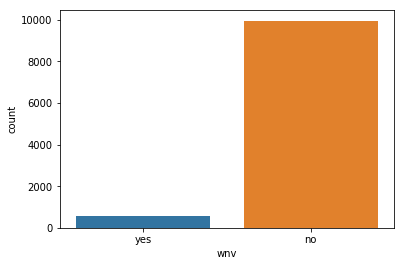

In [19]:
wnv_present = train['WnvPresent'].sum()
bar_df = pd.DataFrame({'count' : [wnv_present, train.shape[0] - wnv_present], 'wnv' : ['yes', 'no']})
sns.barplot(x='wnv', y='count', data=bar_df)

#### weather

In [42]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [32]:
weather.describe()

,Station,Tmax,Tmin,DewPoint,ResultSpeed,ResultDir
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,1.500000,76.166101,57.810462,53.457880,6.960666,17.494905
std,0.500085,11.461970,10.381939,10.675181,3.587527,10.063609
min,1.000000,41.000000,29.000000,22.000000,0.100000,1.000000
25%,1.000000,69.000000,50.000000,46.000000,4.300000,7.000000
50%,1.500000,78.000000,59.000000,54.000000,6.400000,19.000000
75%,2.000000,85.000000,66.000000,62.000000,9.200000,25.000000
max,2.000000,104.000000,83.000000,75.000000,24.100000,36.000000


In [33]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(15)
memory usage: 506.1+ KB


#### spray

In [47]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [54]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null datetime64[ns]
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


In [ ]:
# Things to work on
# - species
# - location -> several variables available inc. trap, lat and long.
# - weather -> joined on date
# - spray -> joined on date

### EDA II

#### Species

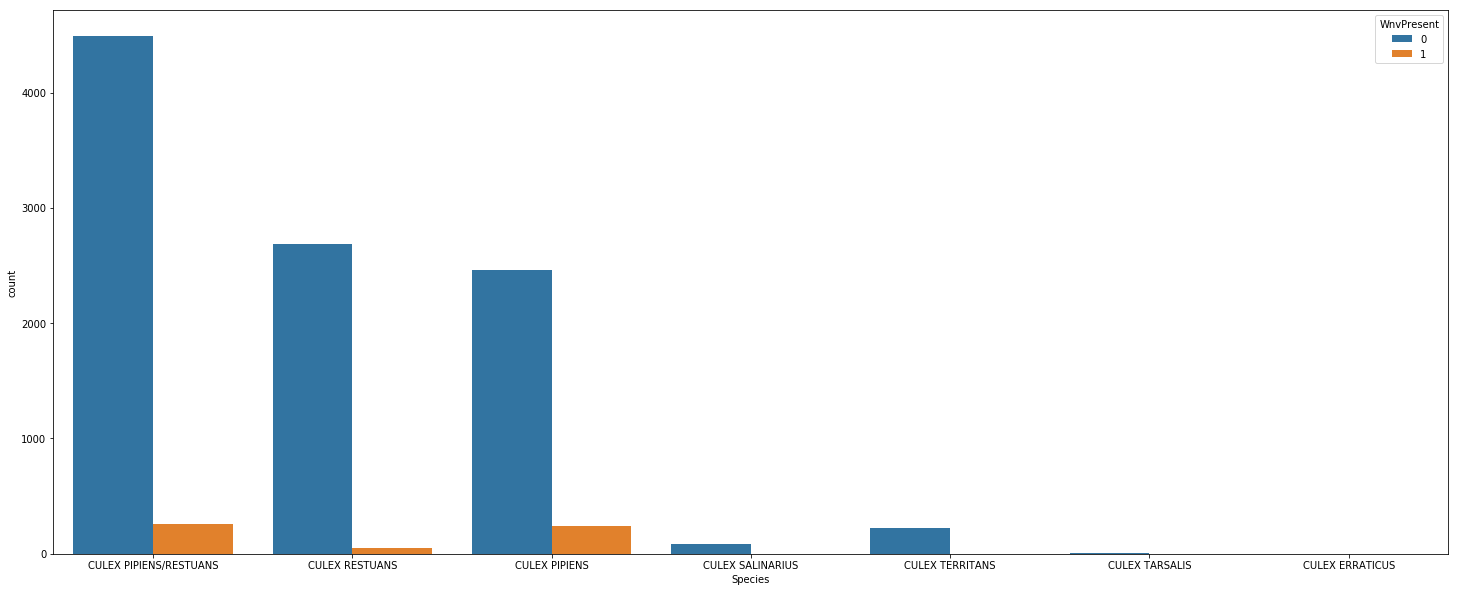

In [102]:
_, ax = plt.subplots(figsize=(25,10))
sns.countplot(x='Species', hue='WnvPresent', data=train, ax=ax)

#### Location

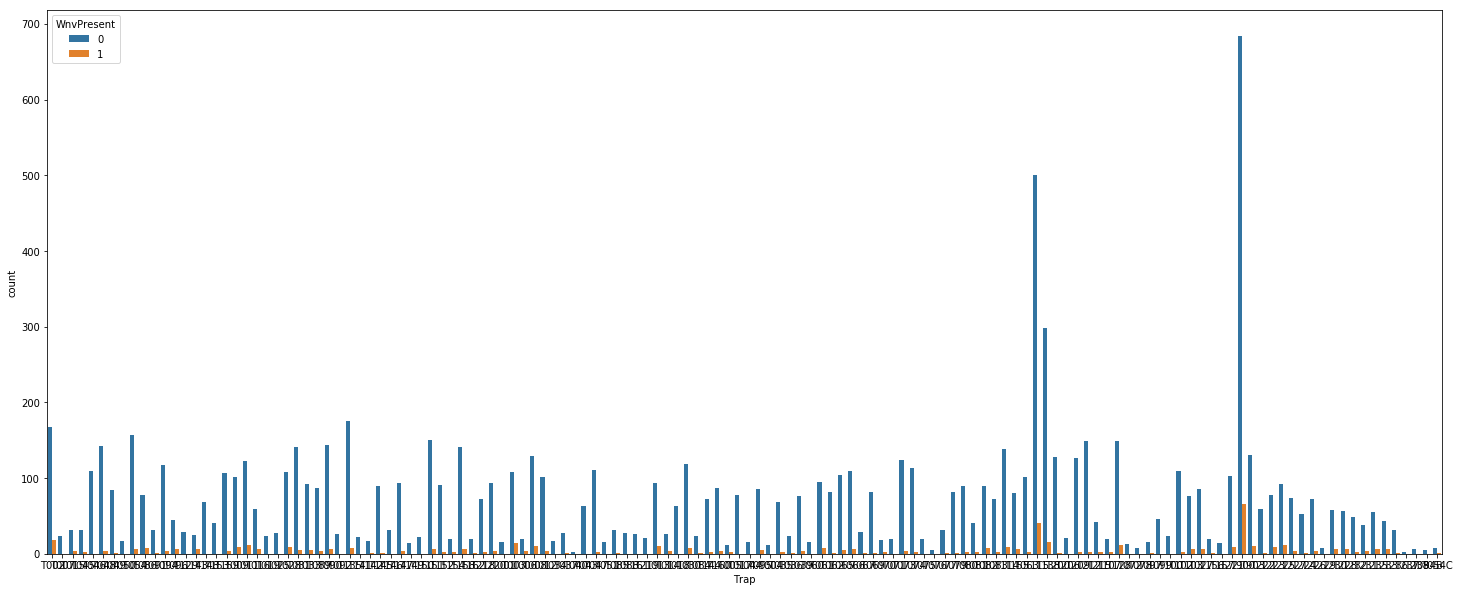

In [104]:
_, ax = plt.subplots(figsize=(25,10))
sns.countplot(x='Trap', hue='WnvPresent', data=train, ax=ax)

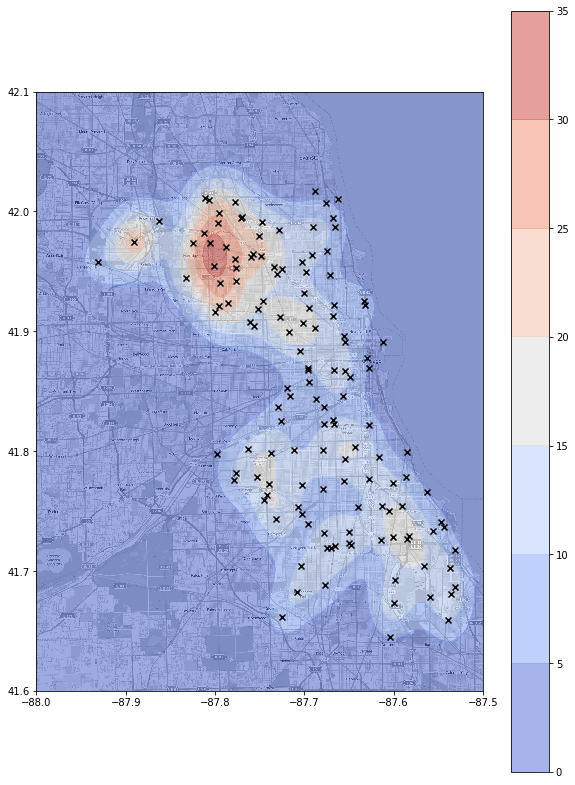

In [206]:
# data
traps = train[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]
locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
infections = traps[traps['WnvPresent'] == True]
# row for day with positive sighting
daily_infections = infections.groupby(['Trap', 'Date', 'Latitude', 'Longitude']).max()['WnvPresent'].reset_index()
daily_infections_ll = daily_infections[['Longitude', 'Latitude']]

# density estimate
kd = KernelDensity(bandwidth=0.02)
kd.fit(daily_infections_ll.values)
lat_min, lat_max = -88, -87.5
lon_min, lon_max = 41.6, 42.1
n = 100
xx,yy = np.linspace(lat_min, lat_max, n), np.linspace(lon_min, lon_max, n)
xx, yy = np.meshgrid(xx, yy)
X = np.vstack([xx.ravel(), yy.ravel()]).T
zz = np.exp(kd.score_samples(X)).reshape(n, n)

# plot contorus of density estimate over map of traps
mapdata = np.loadtxt("data_download/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")
lon_lat_box = (lat_min, lat_max, lon_min, lon_max)
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
# contour plot
plt.figure(figsize=(10,14))
plt.contourf(xx,yy,zz, cmap='coolwarm', alpha=0.5)
plt.colorbar()
# map 
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
# traps
plt.scatter(locations[:,0], locations[:,1], marker='x', c='black')

In [406]:
# - Is pattern stable over time: yearly / monthly plots / time slider
# - How does a knn do?
# - lat/lng feature engineering
# - Is the `AddressAccuracy` column in training set significant?

#### Time of year

In [19]:
def time_infection_density(data, year, start_d, start_m, end_d, end_m, bandwidth_days):
    infections = data[data['WnvPresent'] == True]
    infections_years = infections['Date'].map(lambda x: x.year)
    infections_dates = infections[infections_years == year]['Date']
    min_date, max_date = datetime(year=year, day=start_d, month= start_m), datetime(year=year, day=end_d, month= end_m)
    time_fn = lambda x: (x.timestamp() - min_date.timestamp()) / (60 * 60 * 24)
    X = infections_dates.map(time_fn).values.reshape(-1,1)
    kd = KernelDensity(bandwidth=bandwidth_days).fit(X)
    ts = np.linspace(time_fn(min_date), time_fn(max_date), 1000).reshape(-1,1)
    ds = np.exp(kd.score_samples(ts)).reshape(-1,1)
    return ts, ds, X

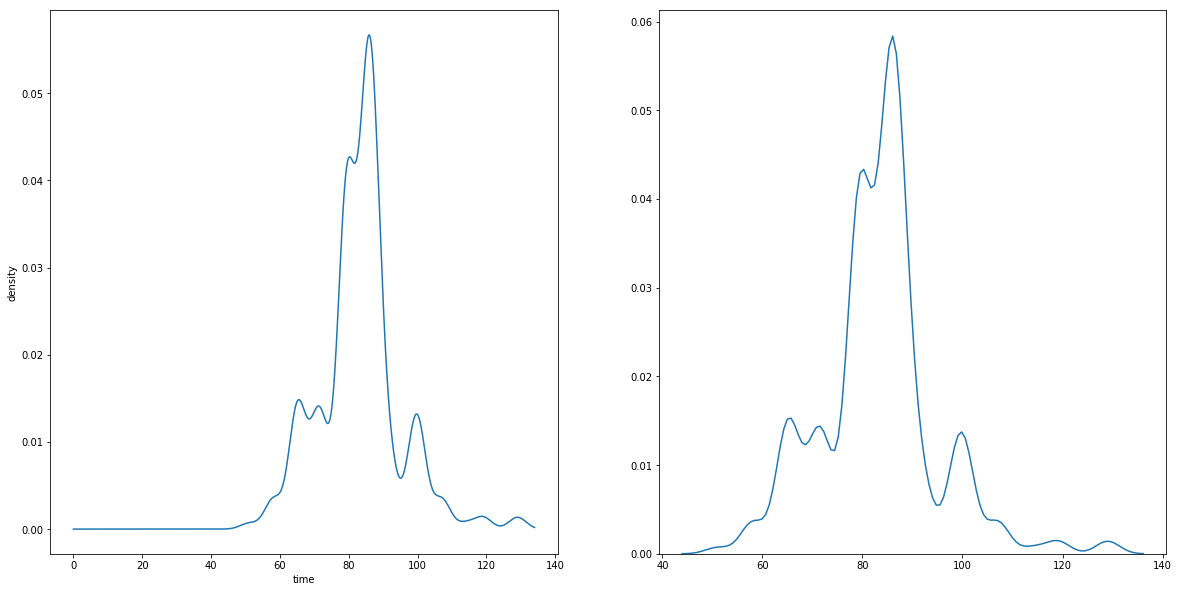

In [20]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
ts, ds, X = time_infection_density(train, 2007, 28, 5, 9, 10,2.5)
density_df = pd.DataFrame({'density' : ds.T[0], 'time' : ts.T[0]})
sns.lineplot(x='time', y='density', data=density_df, ax=ax1)
# sanity check against sns kdeplot
sns.kdeplot(X.T[0], ax=ax2)

In [46]:
train.groupby(train.Date.dt.year)['Date'].agg(['min', 'max'])

,min,max
Date,,
2007,2007-05-29,2007-10-09
2009,2009-05-28,2009-10-01
2011,2011-06-10,2011-09-30
2013,2013-06-07,2013-09-26


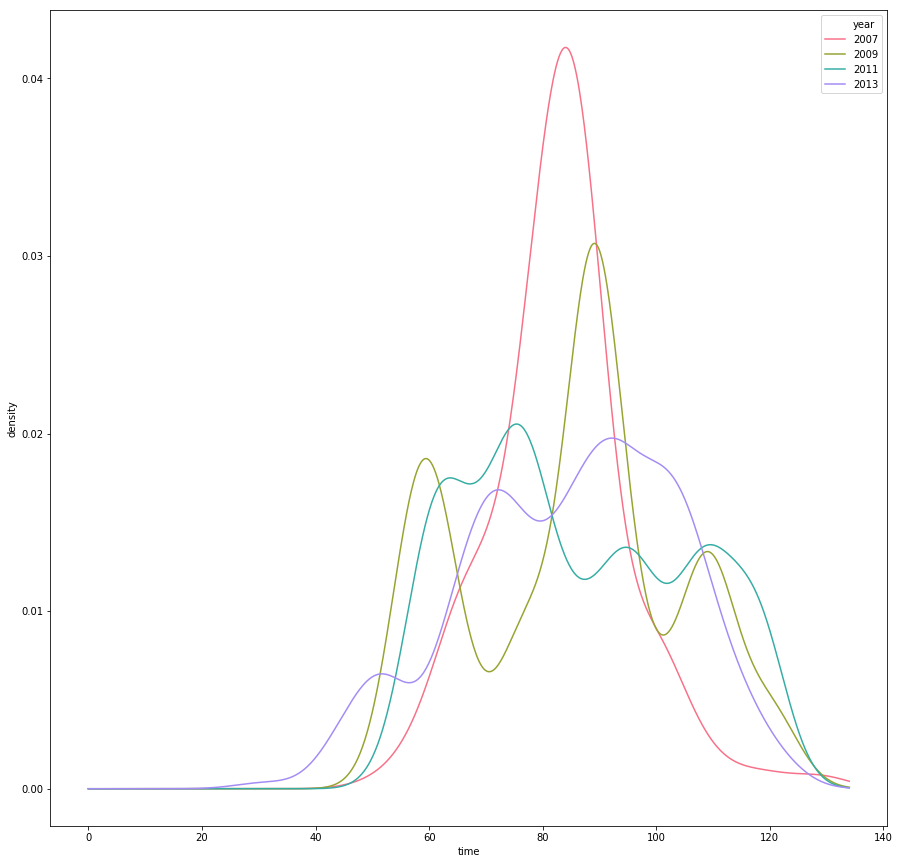

In [125]:
start_d, start_m = 28, 5
end_d, end_m = 9, 10
days_bandwidth = 5

infections = train[train['WnvPresent'] == True]
train_years = infections['Date'].map(lambda x: x.year)
chart_df = pd.DataFrame()
for y in train_years.unique():
    ts, ds, _ = time_infection_density(train, y, 28, 5, 9, 10, days_bandwidth)
    density_df = pd.DataFrame({'density' : ds.T[0], 'time' : ts.T[0], 'year': np.repeat(y, ts.shape[0])})
    chart_df = pd.concat([chart_df, density_df])

_, ax = plt.subplots(figsize=(15, 15))
sns.lineplot(x='time', y='density', hue='year', data=chart_df, ax=ax, palette=sns.color_palette('husl',len(train_years.unique()) ))

#### Weather

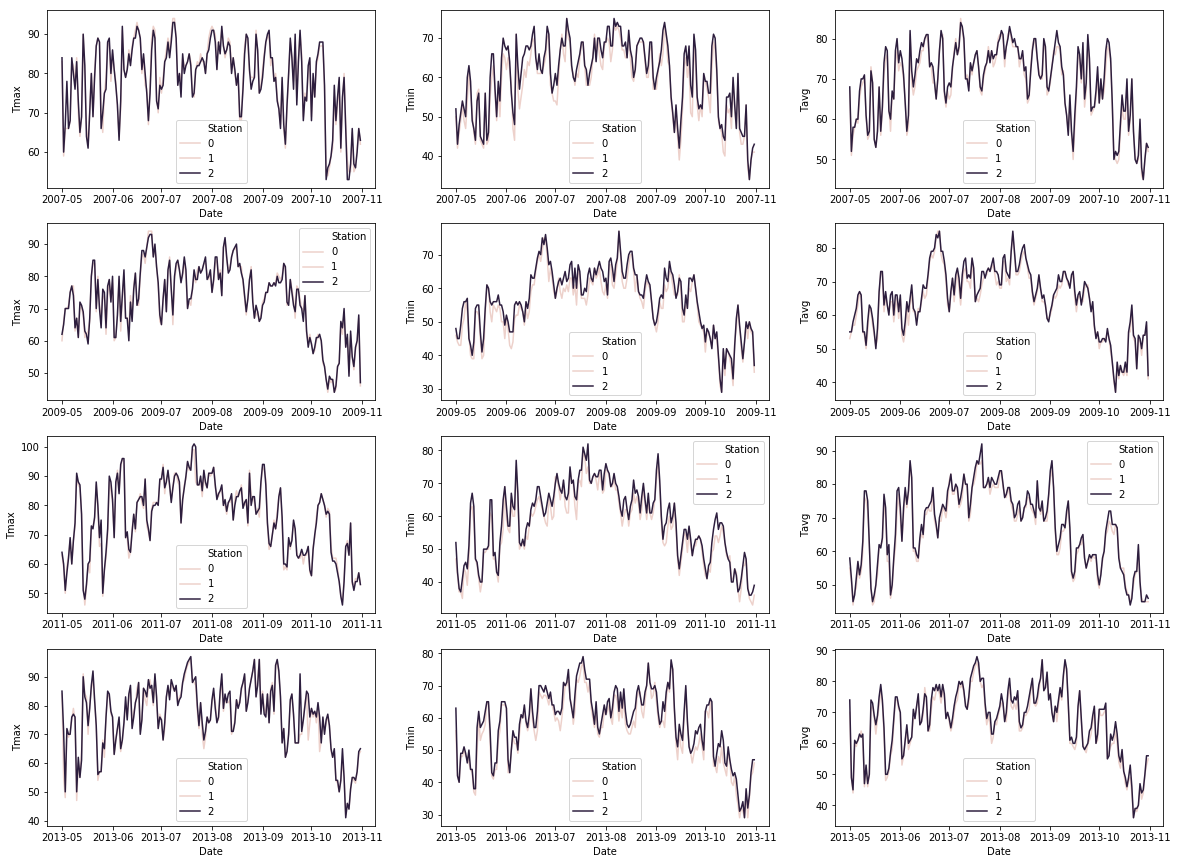

In [138]:
tavg = pd.to_numeric(weather_train['Tavg'].replace('M', method='ffill'))
X = weather_train.copy()
X['Tavg'] = tavg

years = X['Date'].map(lambda x: x.year)
_, axes = plt.subplots(figsize=(20, 15), nrows=len(years.unique()), ncols=3)
for idx, y in enumerate(years.unique()):
    mask = years == y
    window = X[mask]
    sns.lineplot(x='Date', y='Tmax', data=window, hue='Station', ax=axes[idx][0])
    sns.lineplot(x='Date', y='Tmin', data=window, hue='Station', ax=axes[idx][1])
    sns.lineplot(x='Date', y='Tavg', data=window, hue='Station', ax=axes[idx][2])

In [89]:
weather_train.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [ ]:
# group by year and visualise the columns
# station 1 and 2 - how different are the values; use nearest or take average?
# comparison with incidence of WVV
# ?deal with missing / dodgey values

#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

#### Spray

### Pipeline

### Submit

In [90]:
def predict_null_classifier(test):
    return np.repeat(0, test.shape[0])

def write_submit_file(test, preds):
    submit_df = pd.DataFrame({'Id' : test['Id'], 'WnvPresent' : preds})
    file_name = datetime.utcnow().strftime('%H_%M-%d-%m-%Y')
    submit_df.to_csv('./submissions/{}.csv'.format(file_name), index=False)

In [91]:
write_submit_file(test, predict_null_classifier(test))